In [2]:
import numpy as np
import yaml
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from transformers import AutoModel, AutoTokenizer, pipeline

from datasets import load_dataset
import torch

/workspaces/lowem1-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test = "hello world"

In [4]:
with open("experiments.yml") as stream:
  runtime_conf = yaml.safe_load(stream)

In [5]:
global_vars = runtime_conf["global"]
cls_params = global_vars["classifiers"]
pipeline_params = global_vars["pipeline_params"]
dataset_checkpoint = global_vars["dataset_checkpoint"]
checkpoint = global_vars["default_checkpoint"]
checkpoints = global_vars["checkpoints"]

In [6]:
dataset = load_dataset(dataset_checkpoint)["train"].shuffle().select(range(50))
dataset

Found cached dataset parquet (/home/vscode/.cache/huggingface/datasets/lowem1___parquet/lowem1--training-invoices-e93c374bc59d64cc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 1/1 [00:00<00:00, 28.20it/s]


Dataset({
    features: ['label', 'line_data', 'source', 'noise_factor', '__index_level_0__'],
    num_rows: 50
})

In [7]:
le = LabelEncoder()
labels = np.unique(dataset["label"])
le.fit(labels)
dataset = dataset.map(lambda _:dict(label=le.transform([_["label"]])[0],))

In [8]:
def with_embedded_features(row, src_col, model, tokenizer):
    toks = tokenizer.batch_encode_plus(
        row[src_col],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    if "bert" in model.config._name_or_path:
        sents = model(**toks).last_hidden_state
    else:
        sents = model.encoder(**toks).last_hidden_state
    pooled_sentence = torch.mean(sents, dim=1)
    return dict(embeddings=pooled_sentence)

In [9]:
model = AutoModel.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
train, val = dataset.map(with_embedded_features,
            batched=True,
            fn_kwargs=dict(
                src_col="line_data",
                model=model,
                tokenizer=tokenizer,
            )
).with_format("np").select_columns(["embeddings", "label"]).train_test_split(test_size=.2).values()

In [11]:
classifiers = [
    KNeighborsClassifier(
        **cls_params["KNeighborsClassifier"]
    ),
    DecisionTreeClassifier(
        **cls_params["DecisionTreeClassifier"]
    ),
    MLPClassifier(
        **cls_params["MLPClassifier"]
    ),
    LogisticRegression(
        **cls_params["LogisticRegression"]
    ),
    AdaBoostClassifier(
        **cls_params["AdaBoostClassifier"]
    ),
    GaussianNB(
        **cls_params["GaussianNB"]
    ),
]
classifier_names = list(cls_params.keys())


In [103]:
def do_train(x_train, y_train, x_val, y_val, checkpoint) -> list:
    # we only want to encode once to lower time complexity
    clsf_metrics = []

    # classifier loop
    for clsf, clsf_n in zip(classifiers, classifier_names):
        # build sklearn preprocessing pipeline for normalization
        # don't want to blow up our weights during regularization 
        model = make_pipeline(
            StandardScaler(with_mean=False),
            clsf,
        )
        model.fit(x_train, y_train.T)
        output = model.predict(x_val)
        # acc, auc, f1 = (
        acc = (
            accuracy_score(y_val, output)
        )
        f1 = (
            # roc_auc_score(y_val, output, average="macro", multi_class="ovo"),
            f1_score(y_val, output, average="macro")
        )
        record = { "classifier": f"{clsf_n}-{checkpoint}",
        "accuracy": acc,
        # "area_under_curve": auc,
        "f1_score": f1
        }
        print(record)
        clsf_metrics.append(record)
    return clsf_metrics

In [104]:
x_train = train["embeddings"]
y_train = train["label"]
x_val = val["embeddings"]
y_val = val["label"]

In [105]:
res = do_train(x_train ,y_train, x_val, y_val, checkpoint)

{'classifier': 'KNeighborsClassifier-bert-base-uncased', 'accuracy': 1.0, 'f1_score': 1.0}
{'classifier': 'DecisionTreeClassifier-bert-base-uncased', 'accuracy': 0.5, 'f1_score': 0.32222222222222224}
{'classifier': 'MLPClassifier-bert-base-uncased', 'accuracy': 0.8, 'f1_score': 0.625}
{'classifier': 'LogisticRegression-bert-base-uncased', 'accuracy': 0.7, 'f1_score': 0.5416666666666666}
{'classifier': 'AdaBoostClassifier-bert-base-uncased', 'accuracy': 0.7, 'f1_score': 0.49999999999999994}
{'classifier': 'GaussianNB-bert-base-uncased', 'accuracy': 0.8, 'f1_score': 0.7222222222222222}


In [106]:
def with_model_selection(checkpoint) -> dict:
    model = AutoModel.from_pretrained(checkpoint)
    tokenier = AutoTokenizer.from_pretrained(checkpoint)
    train, val = dataset.map(with_embedded_features,
            batched=True,
            fn_kwargs=dict(
                src_col="line_data",
                model=model,
                tokenizer=tokenizer,
            )
    ).with_format("np").select_columns(["embeddings", "label"]).train_test_split(test_size=.2).values()
    x_train = train["embeddings"]
    y_train = train["label"]
    x_val = val["embeddings"]
    y_val = val["label"]
    res = do_train(x_train ,y_train, x_val, y_val, checkpoint)
    return res
    

In [107]:
report =  list(map(with_model_selection, checkpoints))

Loading cached processed dataset at /home/vscode/.cache/huggingface/datasets/lowem1___parquet/lowem1--training-invoices-e93c374bc59d64cc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-2320f58018ff1c70.arrow


{'classifier': 'KNeighborsClassifier-t5-small', 'accuracy': 0.9, 'f1_score': 0.7142857142857143}
{'classifier': 'DecisionTreeClassifier-t5-small', 'accuracy': 0.7, 'f1_score': 0.5476190476190476}
{'classifier': 'MLPClassifier-t5-small', 'accuracy': 0.8, 'f1_score': 0.5972222222222222}
{'classifier': 'LogisticRegression-t5-small', 'accuracy': 0.8, 'f1_score': 0.625}
{'classifier': 'AdaBoostClassifier-t5-small', 'accuracy': 0.8, 'f1_score': 0.7809523809523808}
{'classifier': 'GaussianNB-t5-small', 'accuracy': 0.8, 'f1_score': 0.6309523809523809}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/vscode/.cache/huggingface/datasets/lowem1___parquet/lowem1--training-invoices-e93c374bc59d64cc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f39

{'classifier': 'KNeighborsClassifier-bert-base-uncased', 'accuracy': 0.5, 'f1_score': 0.29285714285714287}
{'classifier': 'DecisionTreeClassifier-bert-base-uncased', 'accuracy': 0.7, 'f1_score': 0.375}
{'classifier': 'MLPClassifier-bert-base-uncased', 'accuracy': 0.6, 'f1_score': 0.34848484848484845}
{'classifier': 'LogisticRegression-bert-base-uncased', 'accuracy': 0.6, 'f1_score': 0.3246753246753247}
{'classifier': 'AdaBoostClassifier-bert-base-uncased', 'accuracy': 0.5, 'f1_score': 0.31666666666666665}
{'classifier': 'GaussianNB-bert-base-uncased', 'accuracy': 0.6, 'f1_score': 0.34848484848484845}


<Axes: ylabel='classifier'>

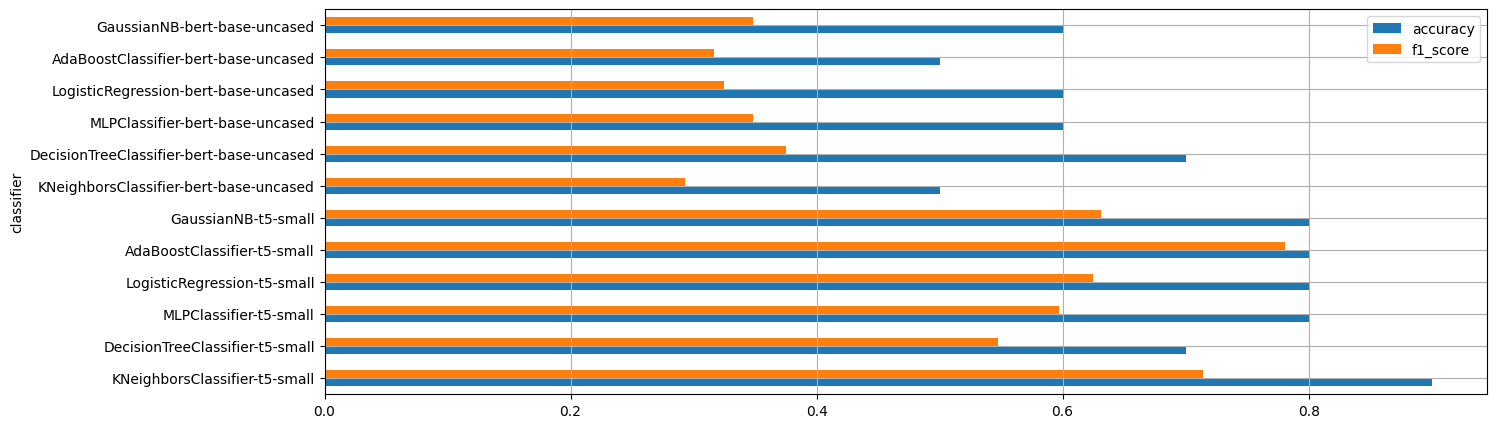

In [130]:
pd.concat(pd.DataFrame(_) for _ in report).plot.barh(x='classifier', figsize=(15,5), grid=True)